In [1]:
from matplotlib import pyplot as plt 

In [2]:
import json

In [3]:
import re

In [4]:
import numpy as np

In [5]:
def bucket(x, size):
    l = len(x)
    buckets = []
    i = 0
    while i < l:
        buckets.append(sum(x[i:i+size])/len(x[i:i+size]))
        i+=size
    return buckets

In [6]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [41]:
class LogReader():
    def __init__(self, filename, keys):
        self.file = open(f'{filename}')
        self.rgx = re.compile(f'^({"|".join(keys)}).*')
        self.matches = {}
        for key in keys:
            self.matches[key]=[]
    
    def grab(self):
        line = next(self.file, None)
        while line:
            match = self.rgx.match(line)
            if match:
                self.matches[match.group(1)].append(float(line.strip().split(' ')[-1]))
            line = next(self.file, None)
        return self.matches

In [127]:
keys = [
    'Batch',
    'Epoch',
    'train zero one loss',
    'train value loss',
    'train prediction loss',
    'validation zero one loss',
    'validation value loss',
    'validation prediction loss',
]

#### Bucket Size

In [128]:
bucket_size = 10

In [129]:
readers = {}
matches = {}

#### Timestamp of run

In [170]:
timestamps = [
'20211027-0915',
'20211027-0926',
'20211027-0952',
]
files = [f'logs/train_earl_{tmstp}.log' for tmstp in timestamps]

In [171]:
for file in files:
    if file not in readers:
        readers[file] = LogReader(file, keys)
        matches = readers[file].grab()

## Get matching log lines

In [193]:
idx = 2
file = files[idx]
matches = readers[file].grab()

## Parameters of this run

In [194]:
import json
from pprint import pprint

In [195]:
pprint(json.load(open(f'logs/earl_params_{timestamps[idx]}.json')))

{'checkpoint': 50,
 'device': 'cuda:2',
 'layers': [['SAGEConv', {'out_channels': 128}],
            ['SAGEConv', {'out_channels': 128}],
            ['SAGEConv', {'out_channels': 128}],
            ['GATConv', {'heads': 2, 'out_channels': 64}]],
 'lr': 0.001,
 'n_epochs': 10,
 'out_mlp': {'bias': True,
             'dim_in': 128,
             'dim_inner': 256,
             'dim_out': 1,
             'num_layers': 3},
 'train_batch_size': 100,
 'validation_batch_size': 100}


## Current Epoch

In [196]:
epoch = matches['Epoch'][-1]
epoch

0.0

## Current Batch

In [197]:
batch = matches['Batch'][-1]
batch

5.0

## Training loss

0.8101892168479599


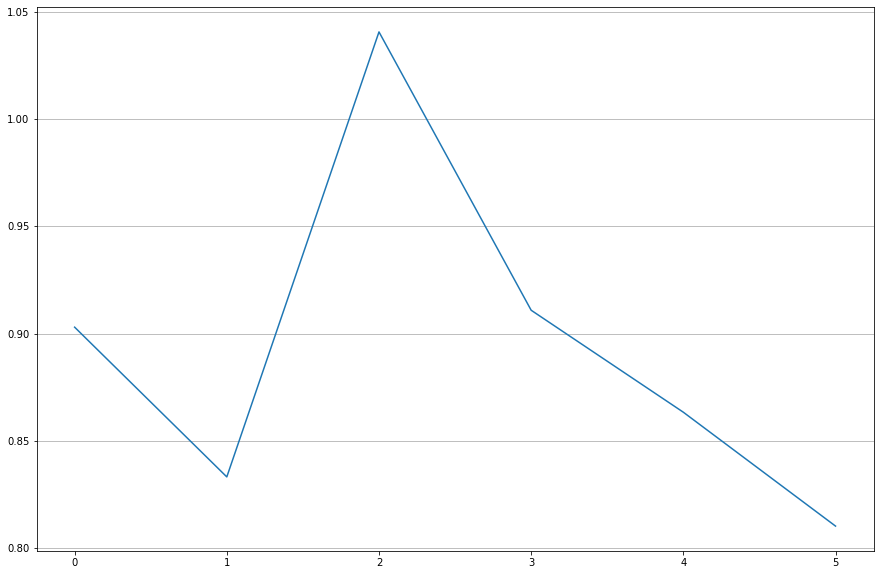

In [198]:
training_loss = matches['train prediction loss']
plt.figure(figsize=(15,10))
plt.grid(axis='y')
_=plt.plot(training_loss)
print(training_loss[-1])

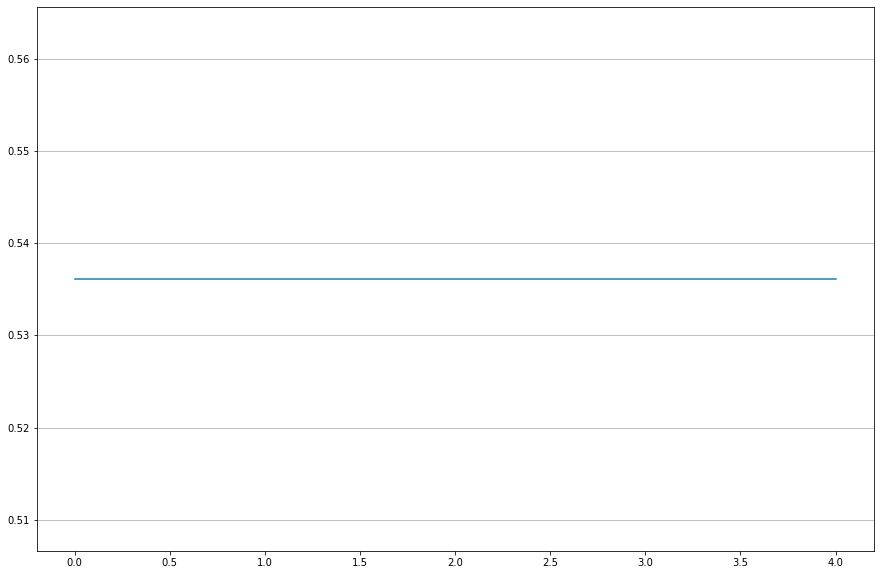

In [199]:
training_loss = matches['train prediction loss']
plt.figure(figsize=(15,10))
plt.grid(axis='y')
_=plt.plot(moving_average(training_loss,10))

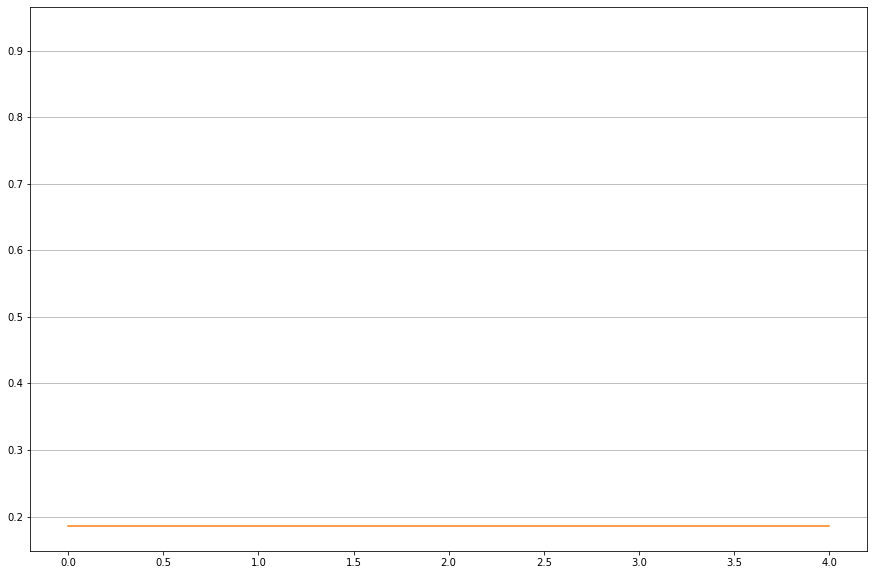

In [200]:
validation_loss = matches['validation prediction loss']
plt.figure(figsize=(15,10))
plt.grid(axis='y')
plt.plot(validation_loss)
_=plt.plot(moving_average(validation_loss,5))

## Sample predictions

In [201]:
prediction_file = open(f'logs/train_earl_prediction_sample_{timestamps[idx]}.log')

In [202]:
for line in prediction_file:
    print(line.strip())

batch 0 0      pred,y:   0.621 1.199
batch 0 1      pred,y:   0.971 0.690
batch 0 2      pred,y:   0.561 0.286
batch 0 3      pred,y:   0.409 0.286
batch 0 4      pred,y:  -2.787 0.508
batch 0 5      pred,y:   0.614 0.690
batch 0 6      pred,y:   0.978 2.228
batch 0 7      pred,y:   1.045 0.000
batch 0 8      pred,y:   0.595 1.094
batch 0 9      pred,y:   0.036 0.286
batch 0 10     pred,y:   0.534 0.000
batch 0 11     pred,y:   1.152 2.329
batch 0 12     pred,y:   0.476 1.199
batch 0 13     pred,y:   1.242 0.977
batch 0 14     pred,y:   0.738 0.000
batch 0 15     pred,y:   0.626 0.000
batch 0 16     pred,y:   0.546 1.891
batch 0 17     pred,y:   0.371 0.000
batch 0 18     pred,y:   1.134 0.000
batch 0 19     pred,y:   0.000 0.508
batch 0 20     pred,y:   0.000 0.690
batch 0 21     pred,y:   0.000 0.286
batch 0 22     pred,y:   0.927 0.690
batch 0 23     pred,y:   0.682 0.000
batch 0 24     pred,y:   0.414 1.381
batch 0 25     pred,y:   0.568 1.840
batch 0 26     pred,y:   0.000 0.508
b